# Magnitudes

We commonly describe an earthquakes size based on it's magnitude. There are various magnitude scales in use, but all
vary logarithmicly. In a general sense, the energy released by a magnitude 2 earthquake is ten times greater than a 
magnitude 1. However, most magnitude scales are not perfectly related to energy, only the moment magnitude ($M_W$) scale
is tied directly to energy release.

In this notebook we will look at how the following magnitudes are calculated:
- Local Magnitude ($M_L$;
- Coda-duration Magnitude ($M_D$);
- Moment Magnitude ($M_W$);
- W-phase derived Moment Magnitude ($M_{WW}$).

The theory behind most of this can be found in Section 4.6 of Stein and Wysession. For more information on the W-phase
moment magnitude method (which is now routinely in use by USGS for fast determination of large earthquake magnitudes),
see [Duputel et al., 2012](https://academic.oup.com/gji/article/189/2/1125/621962).

For a list of other commonly used scales, see the [USGS table of magnitude.](https://earthquake.usgs.gov/learn/topics/mag-intensity/magnitude-types.php)

## Local Magnitude

$M_L$ began life as the *Richter magnitude*, however, this is a magnitude scale with specific scaling parameters for Southern
California. The same equation form used in the initial Richter scale is used elsewhere, but with appropriate attenuation
parameters: thus, if anyone is caught discussing how large earthquakes are in New Zealand *on the Richter scale* they will
be removed from the class!

$M_L$ is based on the measurement of the peak amplitude in a waveform recorded by a *Wood-Anderson* seismometer. There are
very few Wood-Anderson seismometers still in operation today, but we know what the instrument response of a Wood-Anderson
instrument is, and can therefore simulate Wood-Anderson waveforms from other instruments.  The original Richter local magnitude
scale is:

\begin{equation*}
    M_L = \log{A} + 2.76\log{\Delta} - 2.48
\end{equation*}
where $A$ is the peak amplitude (in micro-meters) on a Wood-Anderson seismometer, $\Delta$ is the epicentral distance. This only works
well for shallow earthquakes. The second term effectively corrects for geometrical spreading, while the final factor
is included to scale the magnitude.

Recent work by [Michailos et al., 2019](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2018GC007743) derived
a robust local magnitude scale for the Southern Alps tied to moment magnitude:

\begin{equation*}
    M_L = \log{A} + \log{r} + \eta r - S - 3.644
\end{equation*}
where $r$ is the hypocentral distance, $\eta$ is an attenutaion parameter, which, for $r\le 60km$ is $1.2\times 10^{-2}km^{-1}$
and for $r>60km$ is $0.01\times 10^{-2}km{-1}$. $S$ is a site dependent correction which incorporate local site effects. Geometrical
spreading is assumed to be logarthimically related to $r$, with a gradient of 1.

Lets look at how we would pick an amplitude for local magnitude for a nearby earthquake. We will use the `seismic_picker.py` applet again
which has been extended to allow amplitude and duration picks to be made:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from obspy.clients.fdsn import Client

client = Client("GEONET")
event = client.get_events(eventid="2019p304574")[0]
# Lets just use the closest five weak motion stations
clean_event = event.copy()
clean_event.amplitudes = []
clean_event.station_magnitudes = []
clean_event.picks = [
    p for p in sorted(event.picks, key=lambda p: p.time) 
    if p.waveform_id.channel_code[0] != "B"][0:5]

bulk = [
    (p.waveform_id.network_code, p.waveform_id.station_code, 
     p.waveform_id.location_code, p.waveform_id.channel_code[0:-1] + "?", 
     p.time - 60, p.time + 200) for p in clean_event.picks]
st = client.get_waveforms_bulk(bulk)

# We need to response information for the stations so that we can correct
# the repsonse and simulate a wood anderson instrument.
inv = client.get_stations_bulk(bulk, level="response")

To pick local magnitudes we want to simulate a Wood-Anderson instrument.  To do this we can use obspy's 
[remove_response](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.remove_response.html#obspy.core.stream.Stream.remove_response)
and [simulate](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.simulate.html#obspy.core.stream.Stream.simulate) 
methods to remove the instrument response then apply the Wood-Anderson response.

In [2]:
paz_WA = {'poles': [-6.283 + 4.7124j, -6.283 - 4.7124j],
          'zeros': [0 + 0j], 'gain': 1.0, 'sensitivity': 2080}
st_wa = st.copy()
st_wa = st_wa.remove_response(inv, "DISP")
st_wa = st_wa.simulate(paz_remove=None, paz_simulate=paz_WA)

You will have to re-run the above in an interactive Python session to use the picke. Then run the picker. Amplitude picks for
local magnitudes are commonly picked on the vertical channel - they were originally defined as being picked on the
horizontals, but verticals are more common because they are less succeptible to shallow amplification effects. Picks
should be made at the maximum amplitude.  The picker will record your mouse position and add an `Amplitude` and a `Pick`
for that position.

Make your picks using:
	left mouse button: P
	right mouse button: S
	'a': amplitude at mouse location
	'e': end duration at mouse location - needs a P-pick to calculate duration

Picks can be deleted by hovering over them and pressing the middle mouse button


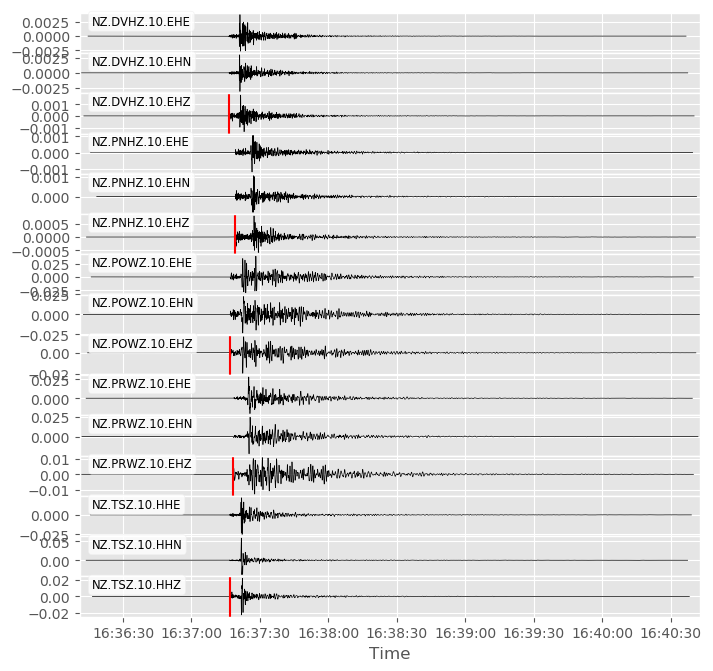

In [3]:
from seismic_picker import seismic_picker

event_out = seismic_picker(st_wa, event_in=clean_event)

The file `magnitude_picked.xml` contains the picks I made. Lets use those to calculate a magnitude. You can replace this with
the picks you made (write then out by running `event_out.write("my_picked_event.xml", format="QUAKEML")`.

Make your picks using:
	left mouse button: P
	right mouse button: S
	'a': amplitude at mouse location
	'e': end duration at mouse location - needs a P-pick to calculate duration

Picks can be deleted by hovering over them and pressing the middle mouse button


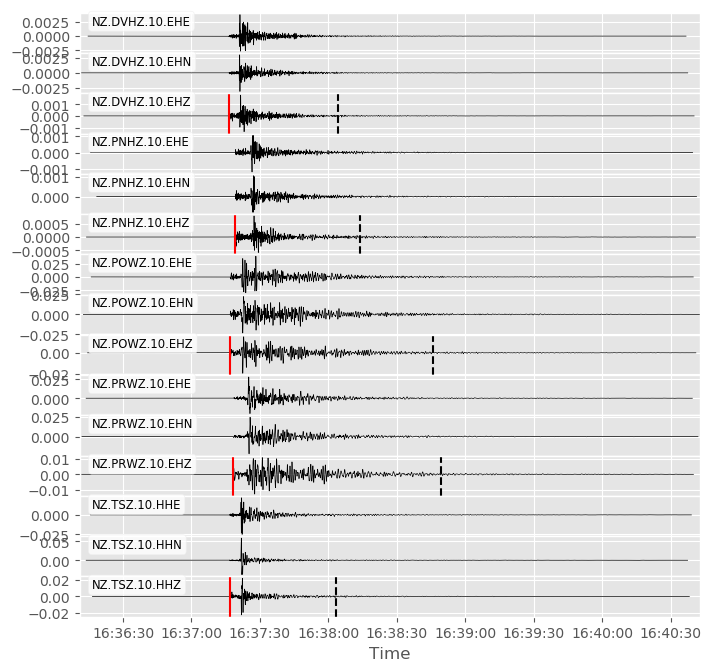

Duration: 47.9749s
Duration: 54.5028s
Duration: 88.9184s
Duration: 90.9022s
Duration: 46.7017s


In [4]:
from obspy import read_events

event_picked = read_events("magnitude_picked.xml")[0]
# Quick plot to check that the picks are recorded in the right place
_ = seismic_picker(st_wa, event_picked)

In [5]:
for amplitude in event_picked.amplitudes:
    if amplitude.type != "END":
        print("Amplitude: {0:.2g} m".format(amplitude.generic_amplitude))

Amplitude: 0.024 m
Amplitude: 0.012 m
Amplitude: 0.17 m
Amplitude: 0.17 m
Amplitude: 0.22 m


We need to know where the earthquake was to calculate the hypocentral distance. We will use the `coordinates.py` classes to
estimate distance (using a flat earth approximation, so only good for local earthquakes).

In [12]:
from coordinates import Geographic
from math import log10

def _distance(point_1, point_2):
    """
    Calcuate hypocentral distance from Geographic points
    
    :type point_1: `coordinates.Geographic`
    :type point_2: `coordinates.Geographic`
    
    :returns: float
    """
    point_2_xyz = point_2.to_xyz(origin=point_1, strike=0, dip=90)
    return (point_2_xyz.x ** 2 + point_2_xyz.y ** 2 + point_2_xyz.z ** 2) ** 0.5

origin = clean_event.preferred_origin()
origin = Geographic(
    latitude=origin.latitude, longitude=origin.longitude, 
    depth=origin.depth / 1000.)
magnitude = 0
used_station_count = 0
for amplitude in event_picked.amplitudes:
    if amplitude.type == 'END':
        continue
    pick = amplitude.pick_id.get_referred_object()
    station_loc = inv.get_coordinates(pick.waveform_id.get_seed_string(),
                                      pick.time)
    station_loc = Geographic(
        latitude=station_loc["latitude"], longitude=station_loc["longitude"],
        depth=(station_loc["local_depth"] - station_loc["elevation"]) / 1000.)
    distance = _distance(origin, station_loc)
    print("Amplitude {0:.2g} m at {1:.2f} km".format(
        amplitude.generic_amplitude, distance))
    station_magnitude = (
        log10(amplitude.generic_amplitude * 1e6) + log10(distance) + 
        0.012 * distance + 1 - 3.644)
    print("Using the Southern Alps ML scale gives: {0}".format(station_magnitude))
    magnitude += station_magnitude
    used_station_count += 1
    
magnitude /= used_station_count
print("Average magnitude: {0}".format(magnitude))
print("GeoNet magnitude: {0}".format(clean_event.preferred_magnitude().mag))

Amplitude 0.024 at 30.59 km
Using the Southern Alps ML scale gives: 3.5958802175505653
Amplitude 0.012 at 50.14 km
Using the Southern Alps ML scale gives: 3.7490745109224726
Amplitude 0.17 at 33.45 km
Using the Southern Alps ML scale gives: 4.50854167000122
Amplitude 0.17 at 41.18 km
Using the Southern Alps ML scale gives: 4.692155882976763
Amplitude 0.22 at 33.67 km
Using the Southern Alps ML scale gives: 4.6257676455112
Average magnitude: 4.234283985392444
GeoNet magnitude: 4.790120006


## Coda-duration Magnitude

Coda-duration magnitude is a simple and fast way of estimating local event magnitude, however this is not in use in New Zealand.
Japan, California, Mexico, Italy and other places all have coda magnitude calculations, so we will select one of these to
compute coda-duration magnitudes.  The principle is to measure the time between the initial P-wave and the time that the
seismogram drops below some noise threshold. How this is defined is different from place-to-place, and coda magnitudes
are usually scaled to some other magnitude. See Page 70 of the [NMSOP, Chapter 3](http://gfzpublic.gfz-potsdam.de/pubman/item/escidoc:108170:12/component/escidoc:364681/Chapter_3.pdf).

We will use the Mexican scale:
\begin{equation*}
    M_d = 2.40\log{d} + 0.00046\Delta - 1.59
\end{equation*}
where d is the duration in seconds.

You can add duration picks to channels with P-phase picks in the picker using the "e" key. I have already made some on
the sample event.

In [15]:
magnitude = 0
used_station_count = 0
for amplitude in event_picked.amplitudes:
    if amplitude.type != 'END':
        continue
    pick = amplitude.pick_id.get_referred_object()
    station_loc = inv.get_coordinates(pick.waveform_id.get_seed_string(),
                                      pick.time)
    station_loc = Geographic(
        latitude=station_loc["latitude"], longitude=station_loc["longitude"],
        depth=(station_loc["local_depth"] - station_loc["elevation"]) / 1000.)
    distance = _distance(origin, station_loc)
    print("Duration {0:.2g} s at {1:.2f} km".format(
        amplitude.generic_amplitude, distance))
    station_magnitude = (
        2.4 * log10(amplitude.generic_amplitude) + 0.00046 * distance - 1.59)
    print("Using the Mexican Md scale gives: {0}".format(station_magnitude))
    magnitude += station_magnitude
    used_station_count += 1
    
magnitude /= used_station_count
print("Average magnitude: {0}".format(magnitude))
print("GeoNet magnitude: {0}".format(clean_event.preferred_magnitude().mag))

Duration 48 s at 30.59 km
Using the Mexican Md scale gives: 2.4585029975013084
Duration 55 s at 50.14 km
Using the Mexican Md scale gives: 2.6004684145259924
Duration 89 s at 33.45 km
Using the Mexican Md scale gives: 3.1029680439649336
Duration 91 s at 41.18 km
Using the Mexican Md scale gives: 3.129522085074112
Duration 47 s at 33.67 km
Using the Mexican Md scale gives: 2.431883674424
Average magnitude: 2.7446690430980696
GeoNet magnitude: 4.790120006


This is clearly too low, which suggests that the code duration is poorly picked, or that the Mexican magnitude scale is
not appropriate for New Zealand. 

Why do you think that might be?

## Moment Magnitude

Moment magnitudes ($M_W$) are defined based on the seismic moment ($M_0$) according to:
\begin{equation*}
    M_W = \frac{\log{M_0}}{1.5} - 10.73
\end{equation*}
with $M_0$ measured in dyne-cm. Using this scale an earthquakes radiated energy can be estimated
provided the stress drop and rigidity are known. Note that seismic moment can not be converted
to energy without knowing these parameters, but is closely related.

$M_W$ is commonly estimated from seismic data either by simulating a source (done routinely in New Zealand
by moment tensor inversion, see Section 4.4.7 of Stein and Wysession), or by measuring corner frequencies 
from earthquake spectra and assuming a simple earthquake source model. For now we will consider analysis of the
corner frequency, but in the [focal mechanism](5_Focal_Mechanisms.ipynb) and the [source-time function](6_Source_Time_Function.ipynb)
notebooks we will consider moment tensor inversions and extended sources.



In [23]:
def plot_fft(tr):
    """
    Calculate the FFT of a discretely sampled series and plot the spectra.
    
    :type y: `numpy.ndarray`
    :param y: Series to calculate FFT for.
    :type dt: float
    :param dt: 
        Sample interval - assumed to be in seconds, so frequencies in Hz.
    """
    import numpy as np
    from scipy import fftpack
    import warnings
    
    x = np.arange(0, tr.stats.npts, dtype=np.float64)
    x *= tr.stats.delta
    x = [(tr.stats.starttime + _).datetime for _ in x]
    y = tr.data
    dt = tr.stats.delta
    
    N = len(y)
    fft_len = fftpack.next_fast_len(N)  # Find the next fast length for the FFT
    yf = fftpack.fft(y, n=fft_len)
    xf = np.linspace(0.0, 1.0 / (2. * dt), int(N / 2))
    yr = fftpack.ifft(yf)
    
    fig, ax = plt.subplots(nrows=2, figsize=(15, 8))
    ax[0].plot(x, y, label="Time series")
    ax[0].set_xlabel("Time (s)")
    ax[0].autoscale(enable=True, axis='both', tight=True)
    ax[0].legend()
       
    ax[1].loglog(xf, 2./N * np.abs(yf[:N//2]), label="Frequency spectra")
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].autoscale(enable=True, axis='both', tight=True)
    ax[1].legend()

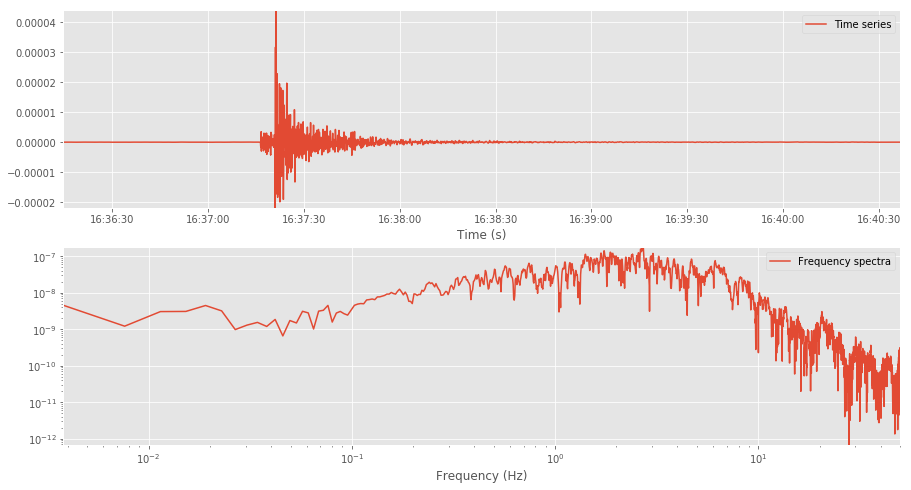

In [25]:
st_disp = st.copy().remove_response(inv, "DISP")
plot_fft(st_disp[0])

## W-phase Moment Magnitude

The W-phase is termed the "whispering" phase.  It occurs as a superposition of body-wave phases. It is now
routinely used to rapidly estimate earthquake magnitude, before the full wavetrain has been recorded. This
makes it very useful for rapid tsunami characterisation.  You should read the paper by 
[Duputal et al.](https://academic.oup.com/gji/article/189/2/1125/621962) to familiarise yourself with why this
is used, and how.